In [5]:
# Install required libraries
!pip install -q pandas numpy re string nltk spacy gensim tqdm scikit-learn

# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
import spacy
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from tqdm.auto import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Enable tqdm for pandas functions
tqdm.pandas()

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


In [6]:
# Load the dataset

df = pd.read_csv('prime_video_reviews_large.csv')
print(" Data loaded successfully.")
df.shape


 Data loaded successfully.


(250000, 6)

In [7]:
df.head(10)

,reviewId,content,Ratings,thumbsUpCount,reviewCreatedVersion,at
0,922ec433-48be-4c59-a505-113497c0400a,The new update brings a lot of needed features...,1,0,NaN,16-09-2025 14:59
1,721a0fe4-8e03-4952-a70c-d216c9f8b726,❤,5,0,3.0.421.1347,16-09-2025 14:50
2,28e0e513-67dc-4f29-8d19-247f2ed31cc7,Poor app. Has crashed since last week. Even if...,1,0,3.0.422.1047,16-09-2025 14:39
3,7065bdaa-cabb-46c6-9e49-079f135a6f3b,"While playing movie, even if wr turn on subtit...",1,7,3.0.417.1647,16-09-2025 13:42
4,39df7cb6-4904-4a1e-93c2-242f12da5050,frequently crash,1,0,3.0.421.1347,16-09-2025 13:24
5,131b764d-84d5-4922-bb5e-3eb0f3bf4e08,low rating for ads,1,0,3.0.421.1347,16-09-2025 13:16
6,89befb2b-8f99-4caa-bd22-07e34cee01c2,"don't like your new streaming service, less th...",1,0,3.0.421.1345,16-09-2025 12:55
7,ea0490a9-8f26-4100-8be0-f58bc0c94f1d,payment karne ke baad bhi movie nahi aa rahi???,1,0,3.0.421.1347,16-09-2025 12:52
8,cb18fc91-44ad-4db1-8fc3-83be8f9e4c49,es una verguenza la cantidad de anuncios que p...,1,0,NaN,16-09-2025 12:49
9,176cbfec-78aa-4e4a-9a56-31db1ff2ca8b,absolutely broken after the last few updates. ...,2,0,3.0.421.1347,16-09-2025 12:31


In [8]:
# --- Data Preprocessing for Amazon Prime Video Reviews ---
# Step 1: Filter out reviews with less than 4 words.
df_filtered = df[df['content'].progress_apply(lambda x: len(str(x).split()) >= 4)].copy()
print(f"Number of rows after filtering: {len(df_filtered)}")

# Step 2: Standardize Case and Clean Text (remove URLs, special characters, emojis, numbers)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # A robust emoji pattern for comprehensive removal
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001f914-\U0001f91F" # new emojis
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    text = re.sub(' +', ' ', text)
    return text.strip()

df_filtered['cleaned_content'] = df_filtered['content'].progress_apply(clean_text)

# Step 3: Create a set of English and domain-specific stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
# Expanded domain-specific stopwords for Amazon Prime Video
custom_stopwords = ['prime', 'video', 'amazon', 'app', 'movie', 'show', 'series', 'film', 'watch', 'like',
                    'really', 'much', 'get', 'well', 'also', 'time', 'day', 'great', 'good', 'excellent', 'best', 'review',
                    'application', 'content', 'play', 'subscription', 'customer', 'service', 'primevideo', 'streaming', 'episode', 
                    'channel', 'screen', 'quality', 'user', 'interface']
stop_words.update(custom_stopwords)

# Step 4: Tokenize and Lemmatize
try:
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
except OSError:
    print("\n SpaCy model 'en_core_web_sm' not found. Please run 'python -m spacy download en_core_web_sm' in your terminal and try again.")
    exit()

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    output = []
    for sent in tqdm(texts, desc="Lemmatizing texts"):
        doc = nlp(sent)
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and token.text.lower() not in stop_words and len(token.text) > 2])
    return output

data_lemmatized = lemmatization(df_filtered['cleaned_content'].tolist())

print(f"\nNumber of reviews after filtering, cleaning and lemmatizing: {len(df_filtered)}")


  0%|          | 0/250000 [00:00<?, ?it/s]

Number of rows after filtering: 171011


  0%|          | 0/171011 [00:00<?, ?it/s]

Lemmatizing texts:   0%|          | 0/171011 [00:00<?, ?it/s]


Number of reviews after filtering, cleaning and lemmatizing: 171011


Training LDA Models:   0%|          | 0/12 [00:00<?, ?it/s]

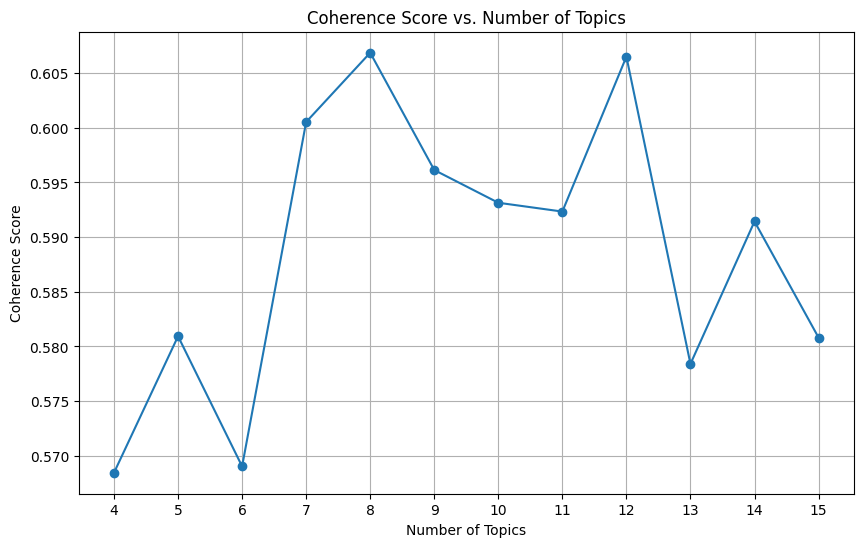

In [9]:
# Create a dictionary and corpus
id2word = Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=15, no_above=0.5) 
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# Function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=1):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step), desc="Training LDA Models"):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, passes=15, alpha='symmetric', eta='auto', workers=None)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Compute coherence values for a range of topics 
limit = 16
start = 4
step = 1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

# Plot the coherence scores
topics_list = list(range(start, limit, step))
plt.figure(figsize=(10, 6))
plt.plot(topics_list, coherence_values, marker='o')
plt.title('Coherence Score vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(topics_list)
plt.grid(True)
plt.show()


In [10]:
# Print the results and find the best model
print("\n--- Coherence Scores by Number of Topics ---")
for m, cv in zip(range(start, limit, step), coherence_values):
    print(f"Num Topics = {m} has Coherence Value of {round(cv, 4)}")



--- Coherence Scores by Number of Topics ---
Num Topics = 4 has Coherence Value of 0.5685
Num Topics = 5 has Coherence Value of 0.5809
Num Topics = 6 has Coherence Value of 0.569
Num Topics = 7 has Coherence Value of 0.6005
Num Topics = 8 has Coherence Value of 0.6069
Num Topics = 9 has Coherence Value of 0.5961
Num Topics = 10 has Coherence Value of 0.5931
Num Topics = 11 has Coherence Value of 0.5923
Num Topics = 12 has Coherence Value of 0.6065
Num Topics = 13 has Coherence Value of 0.5784
Num Topics = 14 has Coherence Value of 0.5914
Num Topics = 15 has Coherence Value of 0.5808


In [11]:
# Get the best model and print its topics
best_model_index = coherence_values.index(max(coherence_values))
best_lda_model = model_list[best_model_index]

from pprint import pprint
print("\nKeywords of the best-performing LDA model:")
pprint(best_lda_model.print_topics())


Keywords of the best-performing LDA model:
[(0,
  '0.023*"watch" + 0.016*"show" + 0.016*"find" + 0.016*"back" + 0.014*"season" '
  '+ 0.014*"make" + 0.014*"want" + 0.012*"go" + 0.012*"start" + 0.012*"use"'),
 (1,
  '0.096*"movie" + 0.082*"love" + 0.058*"show" + 0.035*"use" + 0.034*"easy" + '
  '0.022*"enjoy" + 0.021*"selection" + 0.018*"lot" + 0.016*"nice" + '
  '0.015*"thank"'),
 (2,
  '0.102*"pay" + 0.052*"movie" + 0.039*"free" + 0.034*"money" + '
  '0.023*"membership" + 0.019*"charge" + 0.018*"new" + 0.018*"rent" + '
  '0.018*"extra" + 0.016*"even"'),
 (3,
  '0.045*"download" + 0.028*"account" + 0.021*"try" + 0.019*"even" + '
  '0.018*"say" + 0.017*"use" + 0.017*"sign" + 0.015*"bad" + 0.014*"log" + '
  '0.014*"login"'),
 (4,
  '0.149*"ad" + 0.069*"pay" + 0.024*"commercial" + 0.020*"add" + '
  '0.017*"minute" + 0.017*"many" + 0.016*"get" + 0.015*"watch" + 0.015*"even" '
  '+ 0.012*"still"'),
 (5,
  '0.061*"rent" + 0.055*"buy" + 0.054*"movie" + 0.045*"bad" + 0.032*"purchase" '
  '+ 0

In [12]:
# --- Save the Best Model ---

# Save the model to a file
# The .gensim extension is a common convention, but you can use any name.
best_lda_model.save('best_lda_model.gensim')

print("Best LDA model saved successfully as 'best_lda_model.gensim'")

# --- Load a Saved Model ---
from gensim.models import LdaMulticore

# To load the model, you simply call the .load() method
# Make sure you are using the correct class (LdaMulticore in this case)
loaded_lda_model = LdaMulticore.load('best_lda_model.gensim')

print("\nSaved LDA model loaded successfully!")


Best LDA model saved successfully as 'best_lda_model.gensim'

Saved LDA model loaded successfully!


In [13]:

num_topics = 8

# Create a function to get the topic proportions for a given document
def get_topic_proportions(lda_model, bow_corpus):
    # This will hold the topic proportions for each document
    topic_proportions = []
    # Loop through each document in the corpus
    for doc in tqdm(bow_corpus, desc="Getting topic proportions"):
        # Get topic distribution for the document
        topic_dist = lda_model.get_document_topics(doc, minimum_probability=0)
        # Sort by topic number to ensure consistent order
        topic_dist.sort()
        # Append the proportion for each topic to our list
        topic_proportions.append([prop for topic_num, prop in topic_dist])
    return pd.DataFrame(topic_proportions, columns=[f"Topic_{i+1}" for i in range(num_topics)])

# Get the topic proportions for all filtered reviews
corpus_filtered = [id2word.doc2bow(doc) for doc in data_lemmatized]
X = get_topic_proportions(best_lda_model, corpus_filtered)

# Align the target variable (score) with the features
y = df_filtered['Ratings'].values

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nData prepared for regression models.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

Getting topic proportions:   0%|          | 0/171011 [00:00<?, ?it/s]


Data prepared for regression models.
X_train shape: (136808, 8), y_train shape: (136808,)


In [14]:
# Install required libraries for regression and SHAP
!pip install scikit-learn xgboost shap

In [15]:

# Import necessary libraries
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

# --- OLS Regression ---
print("\n--- Training OLS Regression Model ---")
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
ols_preds = ols_model.predict(X_test)

# Evaluate OLS model
ols_r2 = r2_score(y_test, ols_preds)
ols_mae = mean_absolute_error(y_test, ols_preds)
ols_mse = mean_squared_error(y_test, ols_preds)
print(f"OLS R-squared: {ols_r2:.4f}")
print(f"OLS MAE: {ols_mae:.4f}")
print(f"OLS MSE: {ols_mse:.4f}")

# --- XGBoost Regression ---
print("\n--- Training XGBoost Regression Model ---")
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluate XGBoost model
xgb_r2 = r2_score(y_test, xgb_preds)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_mse = mean_squared_error(y_test, xgb_preds)
print(f"XGBoost R-squared: {xgb_r2:.4f}")
print(f"XGBoost MAE: {xgb_mae:.4f}")
print(f"XGBoost MSE: {xgb_mse:.4f}")

# --- Hybrid Model (Stacked Regression) ---
# The hybrid model will use OLS as a base model and XGBoost as the final estimator
print("\n--- Training Hybrid Stacked Regression Model ---")
estimators = [('ols', LinearRegression())]
hybrid_model = StackingRegressor(estimators=estimators, final_estimator=XGBRegressor(objective='reg:squarederror'))
hybrid_model.fit(X_train, y_train)
hybrid_preds = hybrid_model.predict(X_test)

# Evaluate Hybrid model
hybrid_r2 = r2_score(y_test, hybrid_preds)
hybrid_mae = mean_absolute_error(y_test, hybrid_preds)
hybrid_mse = mean_squared_error(y_test, hybrid_preds)
print(f"Hybrid R-squared: {hybrid_r2:.4f}")
print(f"Hybrid MAE: {hybrid_mae:.4f}")
print(f"Hybrid MSE: {hybrid_mse:.4f}")


--- Training OLS Regression Model ---
OLS R-squared: 0.4051
OLS MAE: 1.0770
OLS MSE: 1.7389

--- Training XGBoost Regression Model ---
XGBoost R-squared: 0.5013
XGBoost MAE: 0.9459
XGBoost MSE: 1.4576

--- Training Hybrid Stacked Regression Model ---
Hybrid R-squared: 0.4374
Hybrid MAE: 1.0283
Hybrid MSE: 1.6446



--- SHAP Analysis for OLS Model ---


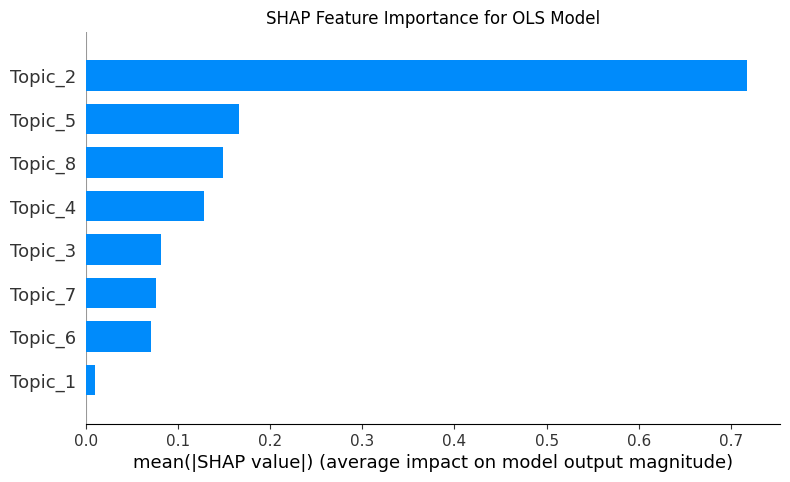


--- SHAP Analysis for XGBoost Model ---


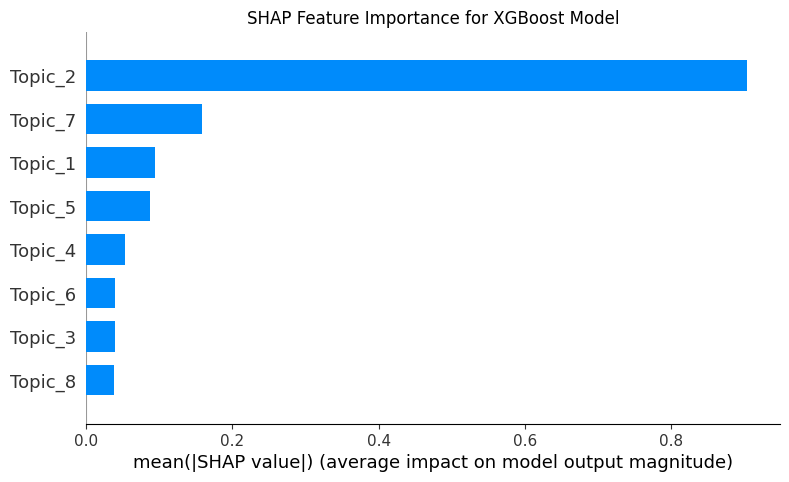

In [16]:
import shap
import matplotlib.pyplot as plt

# --- SHAP Analysis for OLS Model ---
print("\n--- SHAP Analysis for OLS Model ---")
# For linear models, use LinearExplainer
explainer_ols = shap.LinearExplainer(ols_model, X_train)
shap_values_ols = explainer_ols.shap_values(X_test)
shap.summary_plot(shap_values_ols, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for OLS Model")
plt.show()


# --- SHAP Analysis for XGBoost Model ---
print("\n--- SHAP Analysis for XGBoost Model ---")
# For tree-based models, use TreeExplainer
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for XGBoost Model")
plt.show()





In [17]:
# A list of the interpreted topic labels from your LDA model
topic_labels = [
    "Content Navigation & Discovery",
    "Positive Feedback & Content Library",
    "Pricing & Subscription Issues",
    "Account & Login Problems",
    "Advertising & Commercials",
    "Rental & Purchase Experience",
    "App Features & Functionality",
    "Technical Performance & Bugs"
]

# Rename the columns of your feature DataFrame (X) to use these labels
X.columns = topic_labels

# Now, split the data again with the new column names
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


--- SHAP Analysis for OLS Model ---


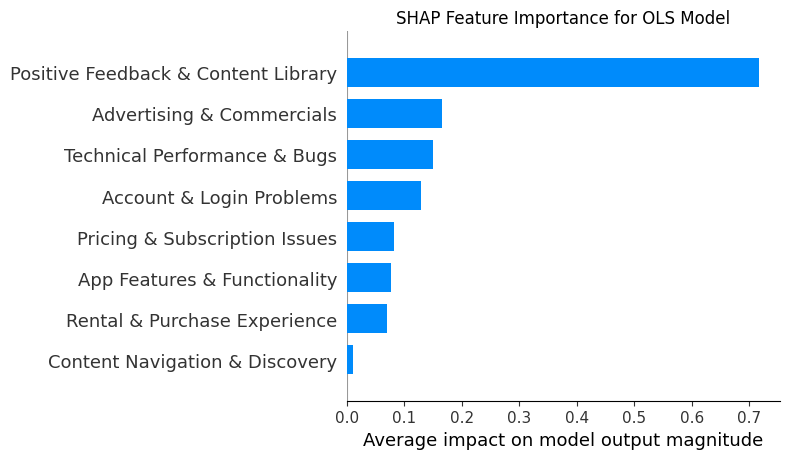

In [18]:
import shap
import matplotlib.pyplot as plt

# --- SHAP Analysis for OLS Model ---
print("\n--- SHAP Analysis for OLS Model ---")
explainer_ols = shap.LinearExplainer(ols_model, X_train)
shap_values_ols = explainer_ols.shap_values(X_test)

# Set a larger figure size to prevent the x-label from being cut off
plt.figure(figsize=(15, 6))
shap.summary_plot(shap_values_ols, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for OLS Model")
plt.xlabel("Average impact on model output magnitude")
plt.tight_layout()
plt.show()


--- SHAP Analysis for XGBoost Model ---


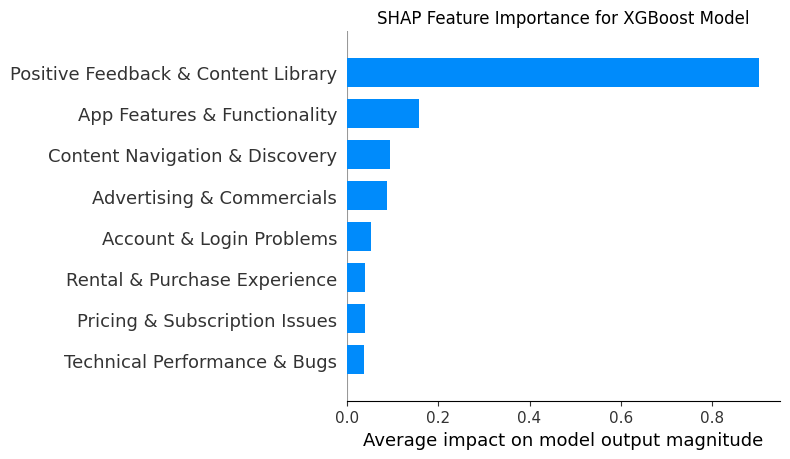

In [19]:


# --- SHAP Analysis for XGBoost Model ---
print("\n--- SHAP Analysis for XGBoost Model ---")
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Set a larger figure size to prevent the x-label from being cut off
plt.figure(figsize=(15, 6))
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for XGBoost Model")
plt.xlabel("Average impact on model output magnitude")
plt.tight_layout()
plt.show()